# NYU Talk (Ocean Transport and Eddy Energy CPT)

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate
from flox.xarray import xarray_reduce
from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [3]:
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16

## Latex

$$K_e = K_\rho \frac{(\partial_z C_e)^2}{|\nabla_n C_m|^2}$$

$$\langle u_t C_t \cdot \nabla C_e \rangle = K_\rho(\partial_z C_e)^2$$

$$\langle u_t C_t \cdot \nabla_n C_m \rangle = K_\rho(\partial_z C_m)^2$$

$$(\partial_z C_e)^2 / [(\partial_z C_e)^2 + (\partial_z C_m)^2]$$

$[1]$ $\langle u_e C_e \rangle \cdot \nabla_n C_m \approx K_e|\nabla_n C_m|^2$

$[2]$ $\langle u_t C_t \cdot \nabla C_e \rangle \approx K_\rho(\partial_z C_e)^2$

$[3]$ $\langle u_t C_t \rangle \cdot \nabla C_m \approx K_\rho(\partial_z C_m)^2$

$[4]$ $\langle \chi \rangle = \kappa_C|\nabla C_t |^2$

$C = C_m + C_e + C_t$

where
- $C$: observed profile
- $C_m$: mean tracer profile
- $C_e$: eddy (mesoscale) tracer profile
- $C_t$: turbulent (microscale) tracer profile

$\langle u_e \theta_e \rangle = K_e |\nabla_n \theta_m |$

$K_e *|\nabla_n \theta_m | *\rho* c_p$

In [4]:
ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_high_res_1.nc')
ct_m = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_m_3.nc')
ct_e = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_e_3.nc')

In [5]:
print(ds.CT.isel(N_PROF=100000).LATITUDE.values, ds.CT.isel(N_PROF=100000).LONGITUDE.values)

-54.81896666666667 125.11388166666667


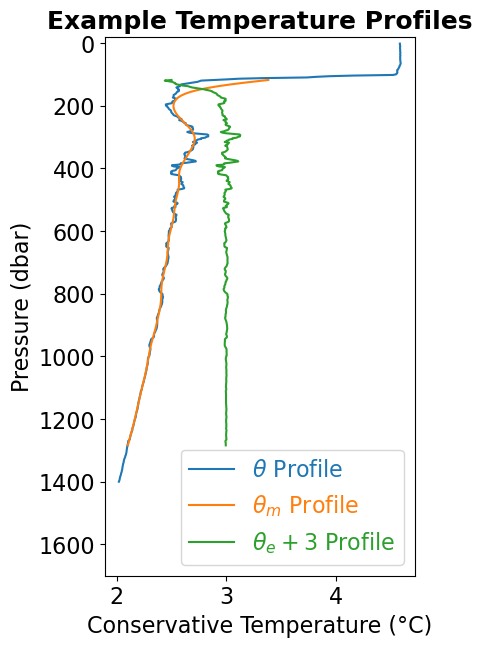

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 7))

# Plot each profile with its own line color
ds.CT.isel(N_PROF=100000).plot(y='PRES_INTERPOLATED', label=r"$\theta$ Profile", color='tab:blue')
ct_m.isel(N_PROF=100000).plot(y='PRES_INTERPOLATED', label=r"$\theta_m$ Profile", color='tab:orange')
(ct_e.isel(N_PROF=100000) + 3).plot(y='PRES_INTERPOLATED', label=r"$\theta_e + 3$ Profile", color='tab:green')

# Axis formatting
plt.gca().invert_yaxis()
plt.ylim(1700, -20)
plt.xlabel('Conservative Temperature (°C)')
plt.ylabel('Pressure (dbar)')
plt.title('Example Temperature Profiles')

# Create legend and customize text colors
legend = plt.legend(loc='lower right')
legend.get_texts()[0].set_color('tab:blue')       # $\theta$
legend.get_texts()[1].set_color('tab:orange')  # $\theta_m$
legend.get_texts()[2].set_color('tab:green')    # $\theta_e + 3$

In [7]:
ds_gridded = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_gridded_3_z.nc')
ds_gridded_rho = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_rho_binned_high_res.nc').rename({'lon_c':'lon','lat_c':'lat'})

In [8]:
term2_ds_CT = xr.open_dataset('/swot/SUM05/amf2288/var-boxes/term2.nc').load()
term2_CT = term2_ds_CT.ct_e_z2_filt.rename('term2')
term3_CT = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/Ke_term3.nc').rename('term3').load()

In [9]:
term2_ds_SA = xr.open_dataset('/swot/SUM05/amf2288/var-boxes/term2_sa.nc').load()
term2_SA = term2_ds_SA.sa_e_z2_filt.rename('term2')
term3_SA = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/term3_sa.nc').rename('term3').load()

In [10]:
K_rho = xr.open_dataset('/swot/SUM05/amf2288/var-boxes/K_rho_3dx.nc').K_filt_3dx

In [11]:
K_e_CT = K_rho*term2_CT/term3_CT

In [12]:
K_e_SA = K_rho*(term2_SA/term3_SA**2)

<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_70405/2170938042.py:14: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f"{title} on density surface: {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");


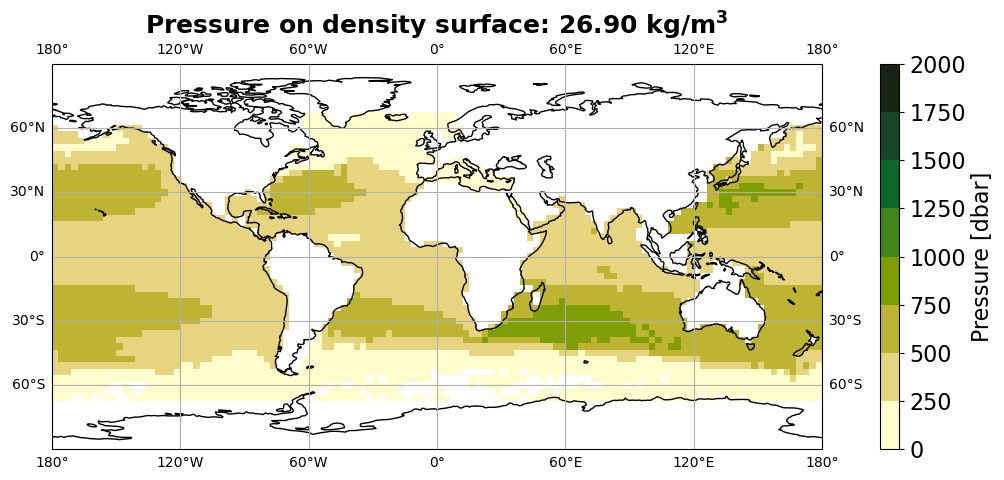

In [50]:
density = 26.9
title= 'Pressure'
units = "dbar"
ds = ds_gridded_rho.PRES.copy(data=ds_gridded_rho.PRES.data)
ds.name = title; ds.attrs["units"] = units
cmap, norm, levels = cmo.speed, colors.Normalize(vmin=0, vmax=2000), np.arange(0, 2001, 250)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, levels=levels)
ax.set_title(f"{title} on density surface: {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_70405/1694291372.py:2: SyntaxWarning: invalid escape sequence '\m'
  title = '$\mathbf{{K_e}}$ from Conservative Temperature'
/tmp/ipykernel_70405/1694291372.py:15: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");


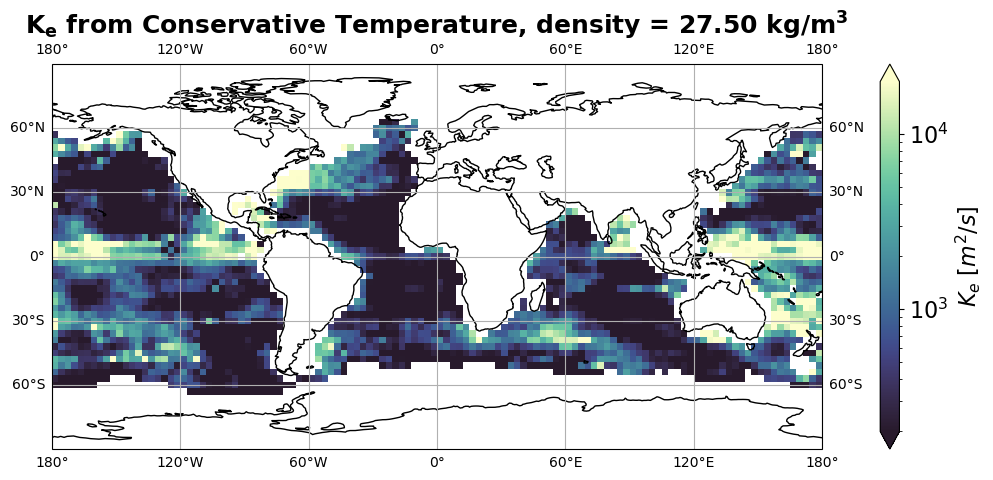

In [33]:
density = 27.5
title = '$\mathbf{{K_e}}$ from Conservative Temperature'
name = '$K_e$'
units = '$m^2/s$'
ds = K_e_CT.copy(data=K_e_CT)
ds.name = name; ds.attrs['units'] = units
cmap, norm = cmo.deep_r, colors.LogNorm(vmin=10**2.3, vmax=10**4.3)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_70405/2802728012.py:2: SyntaxWarning: invalid escape sequence '\m'
  title = '$\mathbf{{K_e}}$ from Absolute Salinity'
/tmp/ipykernel_70405/2802728012.py:15: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");


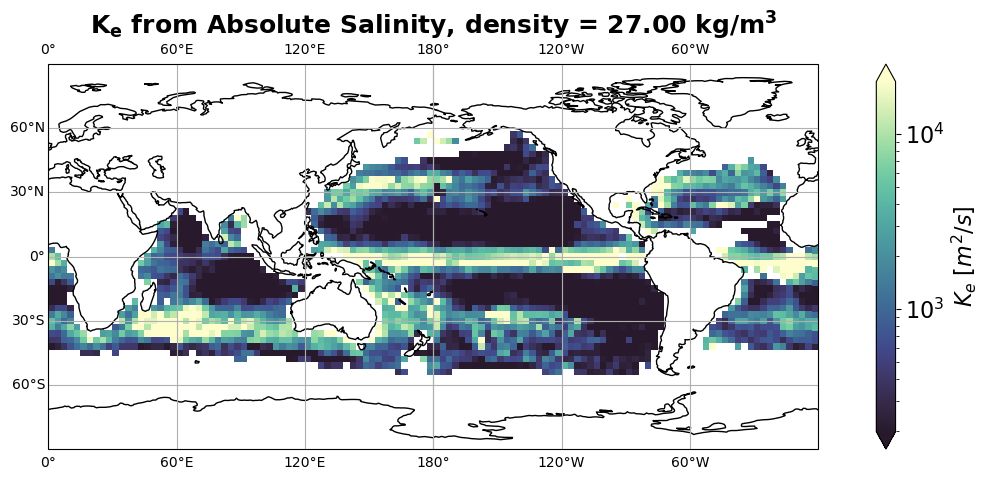

In [56]:
density = 27
title = '$\mathbf{{K_e}}$ from Absolute Salinity'
name = '$K_e$'
units = '$m^2/s$'
ds = K_e_SA.copy(data=K_e_SA)
ds.name = name; ds.attrs['units'] = units
cmap, norm = cmo.deep_r, colors.LogNorm(vmin=10**2.3, vmax=10**4.3)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=True)
ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");

In [36]:
ct_meso_VPR = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_meso_VPR.nc')
ct_micro_VPR = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_micro_VPR.nc')
ct2_frac_VPR = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct2_frac.nc')

<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_70405/670990298.py:15: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");


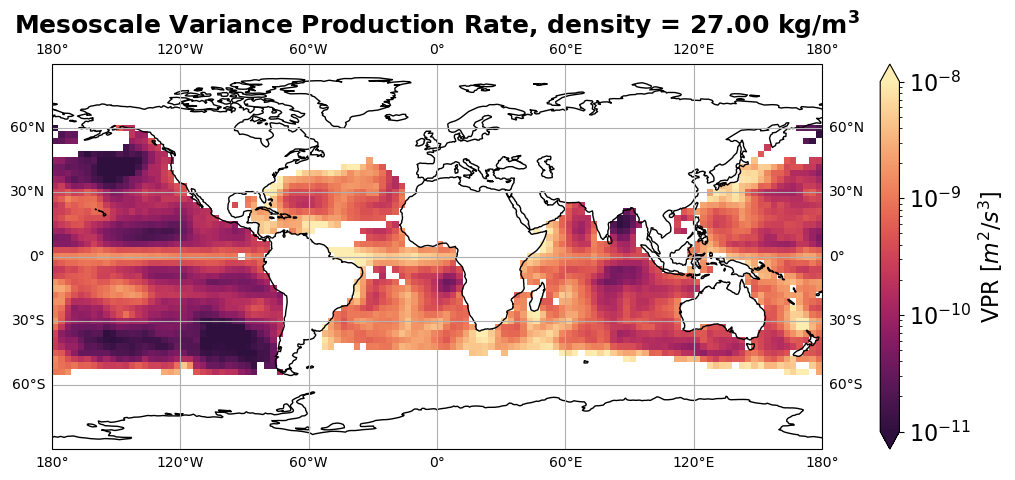

In [40]:
density = 27
title = 'Mesoscale Variance Production Rate'
name = 'VPR'
units = '$m^2/s^3$'
ds = ct_meso_VPR.copy(data=ct_meso_VPR)
ds.name = name; ds.attrs['units'] = units
cmap, norm = cmo.matter_r, colors.LogNorm(vmin=1e-11, vmax=1e-8)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");

<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_70405/4224140942.py:15: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");


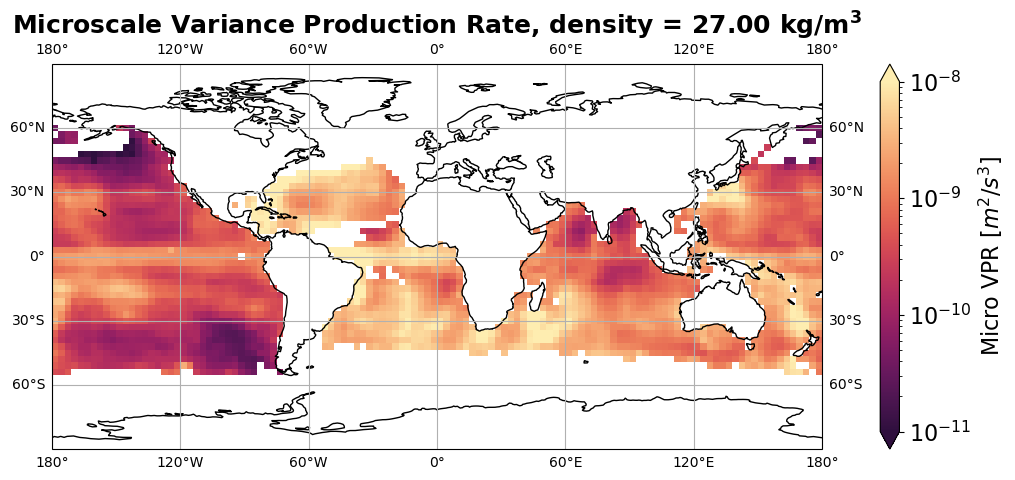

In [57]:
density = 27
title = 'Microscale Variance Production Rate'
name = 'Micro VPR'
units = '$m^2/s^3$'
ds = ct_micro_VPR.copy(data=ct_micro_VPR)
ds.name = name; ds.attrs['units'] = units
cmap, norm = cmo.matter_r, colors.LogNorm(vmin=1e-11, vmax=1e-8)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=True)
ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");

<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_70405/3814330157.py:14: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");


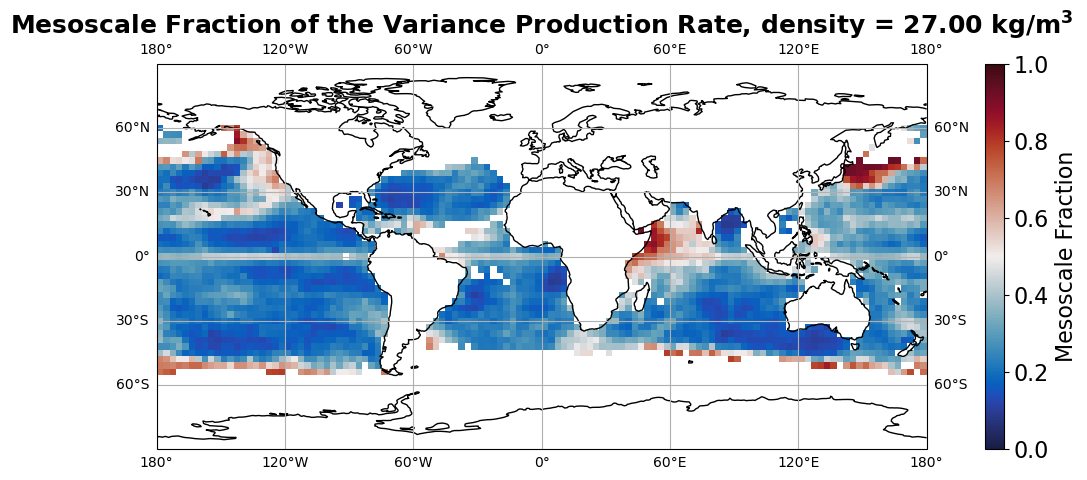

In [42]:
density = 27
title = 'Mesoscale Fraction of the Variance Production Rate'
name = 'Mesoscale Fraction'
ds = ct2_frac_VPR.copy(data=ct2_frac_VPR)
ds.name = name
cmap, norm = cmo.balance, colors.Normalize(vmin=0, vmax=1)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");

In [59]:
dCT_dx = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_m_dx.nc')
dCT_dy = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_m_dy.nc')

In [60]:
F_CT_x = -K_e_CT*dCT_dx
F_CT_y = -K_e_CT*dCT_dy
F_CT_xy = K_e_CT*np.sqrt(dCT_dx**2 + dCT_dy**2)

<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:39: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_70405/2137727873.py:39: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$")


Text(0.5, 1.0, 'Magnitude of the Temperature Flux, density = 27.00 $\\mathbf{kg/m^3}$')

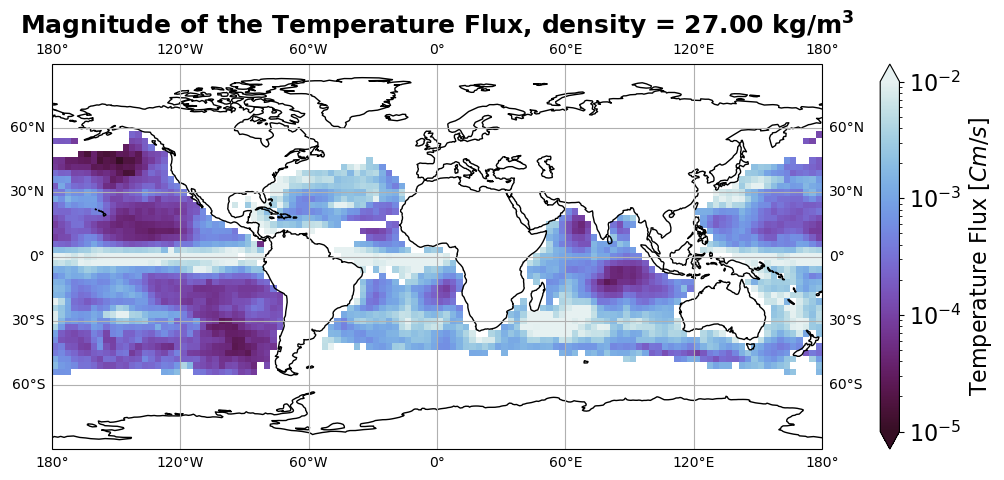

In [70]:
density = 27.
title = 'Magnitude of the Temperature Flux'
name = 'Temperature Flux'
units = '$C m/s$'
ds = F_CT_xy.copy(data=F_CT_xy)
ds.name = name; ds.attrs['units'] = units
cmap, norm = cmo.dense_r, colors.LogNorm(vmin=1e-5, vmax=1e-2)

# Choose a density slice—here using index, but you could use `.sel(density=...)` too
u = F_CT_x.sel(density=density, method='nearest')
v = F_CT_y.sel(density=density, method='nearest')

# Create meshgrid from coordinates for plotting
X, Y = u['lon'], u['lat']
XX, YY = np.meshgrid(X, Y, indexing='ij')  # match xarray's dimension order

# Transpose u and v to match meshgrid shape (lon x lat)
U = u.transpose('lon', 'lat').values
V = v.transpose('lon', 'lat').values

# Mask out extreme vectors
mag = np.sqrt(U**2 + V**2)
threshold = 1e-1  # adjust as needed
mask = mag < threshold
U = np.where(mask, U, np.nan)
V = np.where(mask, V, np.nan)

fig = plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(
    x='lon', y='lat', ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm
)
#q = ax.quiver(XX, YY, U, V, scale=3e-1, pivot='middle', width=0.0015)
#ax.quiverkey(q, X=0.7, Y=0.08, U=5e-3, label=f'{5e23:.0e} gradient units', labelpos='E', color='r', labelcolor='r')
#ax.quiverkey(q, X=0.7, Y=0.04, U=1e-2, label=f'{1e-6:.0e} gradient units', labelpos='E', color='r', labelcolor='r')
ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$")

In [141]:
PF = xr.open_dataarray('/swot/SUM05/amf2288/acc_fronts/CTOH_PolarFront_weekly_1993_2023.nc')
SAF = xr.open_dataarray('/swot/SUM05/amf2288/acc_fronts/CTOH_SubantarcticFront_weekly_1993_2023.nc')

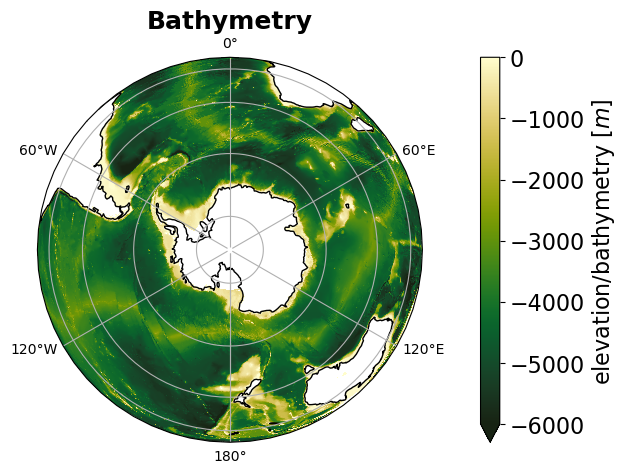

In [293]:
title = 'Bathymetry'
name = 'Bathymetry'
units = '$m$'
ds = bath.copy(data=bath)
ds.name = name; ds.attrs['units'] = units
cmap, norm = cmo.speed_r, colors.Normalize(vmin=-6000, vmax=0)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=0, central_latitude=-90))
ax.coastlines()
ax.gridlines(draw_labels=True)
ds.where(ds<0, drop=True).plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title(f"{title}");

<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_7613/1650076432.py:14: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");


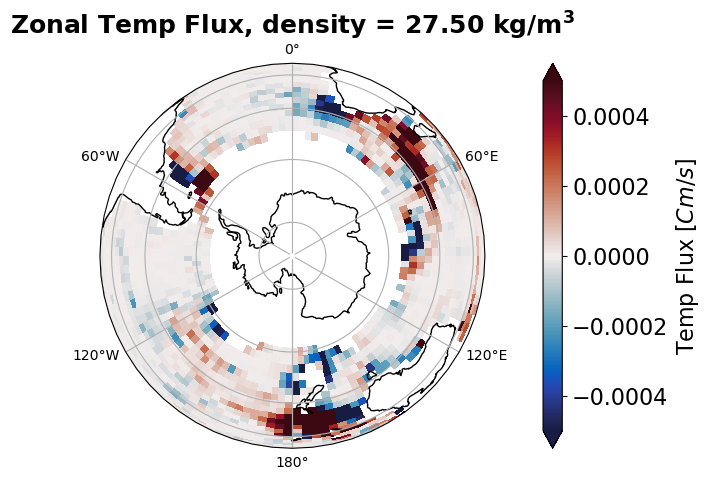

In [276]:
density = 27.50
title = 'Zonal Temp Flux'
name = 'Temp Flux'
units = '$C m/s$'
ds = F_CT_x.copy(data=F_CT_x)
ds.name = name; ds.attrs['units'] = units
cmap, norm = cmo.balance, colors.Normalize(vmin=-0.0005, vmax=0.0005)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=0, central_latitude=-90))
ax.coastlines()
ax.gridlines(draw_labels=True)
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title(f"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");

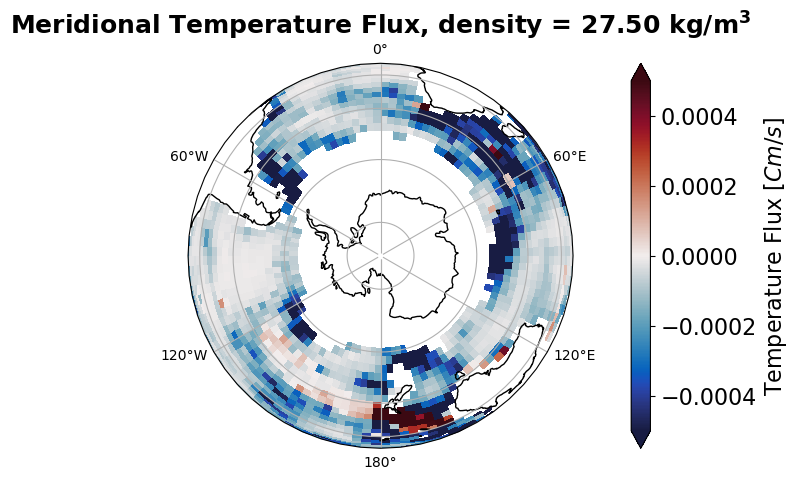

In [291]:
density = 27.50
title = 'Meridional Temperature Flux'
name = 'Temperature Flux'
units = '$C m/s$'
ds = F_CT_y.copy(data=F_CT_y)
ds.name = name; ds.attrs['units'] = units
cmap, norm = cmo.balance, colors.Normalize(vmin=-0.0005, vmax=0.0005)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=0, central_latitude=-90))
ax.coastlines()
ax.gridlines(draw_labels=True)
#ax.set_extent([-180,180,-90,-30], crs=ccrs.PlateCarree())
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
#ax.plot(PF.longitude.mean('time'), PF.mean('time'), color='k', linewidth=1, transform=ccrs.PlateCarree(), label='Mean Polar Front')
#ax.plot(SAF.longitude.mean('time'), SAF.mean('time'), color='k', linewidth=1, transform=ccrs.PlateCarree(), label='Mean Subantarctic Front')
#ax.plot(np.linspace(-180, 180, 100), [-54]*100, color='r', linestyle='--', transform=ccrs.PlateCarree())
ax.set_title(rf"{title}, density = {ds.density.sel(density=density, method='nearest').values.item():.2f} $\mathbf{{kg/m^3}}$");

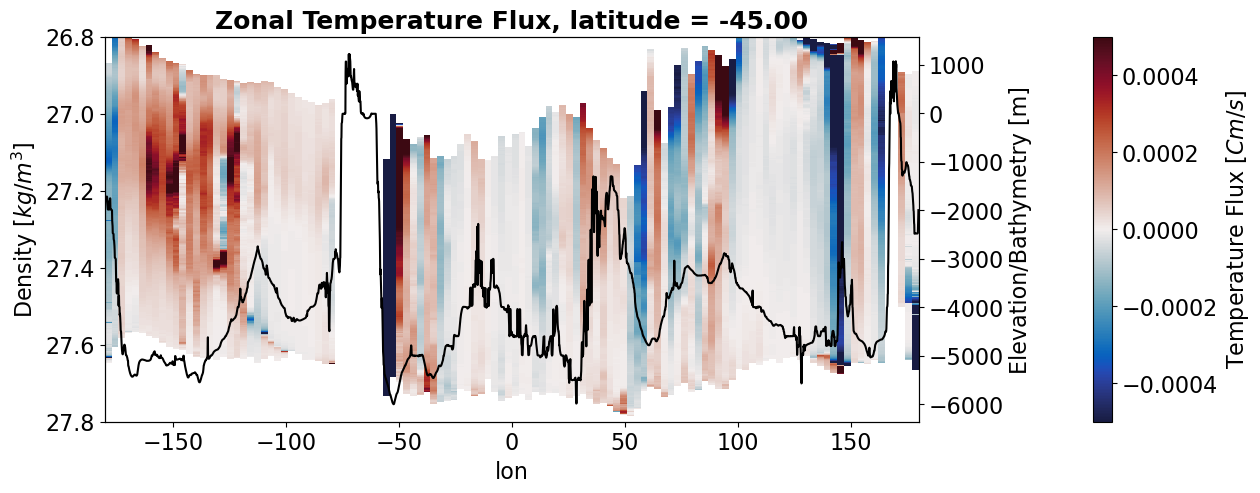

In [302]:
lat = -46
title = 'Zonal Temperature Flux'
name = 'Temperature Flux'
units = '$C m/s$'
ds = F_CT_x.copy(data=F_CT_x)
ds.name = name; ds.attrs['units'] = units
cmap, norm = cmo.balance, colors.Normalize(vmin=-0.0005, vmax=0.0005)

fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot main data without colorbar
p = ds.sel(lat=lat, method='nearest').plot(
    x='lon', y='density', ax=ax1, cmap=cmap, norm=norm,
    add_colorbar=False
)
ax1.set_ylim(27.8, 26.8)
ax1.set_ylabel(r'Density [$kg/m^3$]')
ax1.set_title(rf"{title}, latitude = {ds.lat.sel(lat=lat, method='nearest').values.item():.2f}")

# Twin axis for bathymetry — keep labels tight
ax2 = ax1.twinx()
bath.sel(lat=ds.lat.sel(lat=lat, method='nearest').values, method='nearest').plot(
    x='lon', ax=ax2, color='k'
)
ax2.set_ylabel('Elevation/Bathymetry [m]')
ax2.set_title('')

# Add colorbar far away using fig.colorbar and pad
cbar = fig.colorbar(p, ax=ax1, pad=0.15)  # large pad pushes it far right
cbar.set_label(r'Temperature Flux [$C m/s$]')

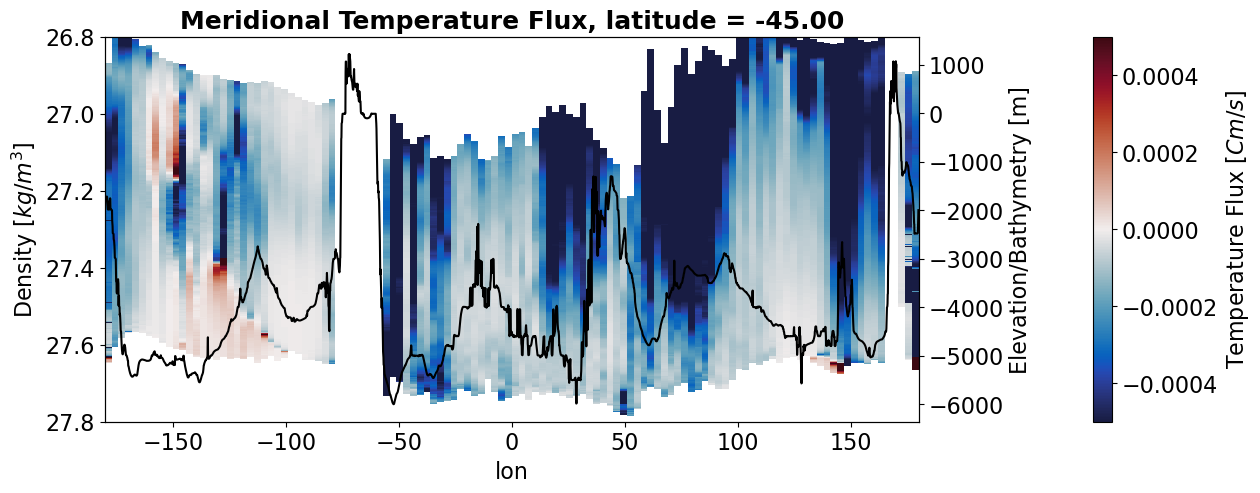

In [303]:
lat = -46
title = 'Meridional Temperature Flux'
name = 'Temperature Flux'
units = '$C m/s$'
ds = F_CT_y.copy(data=F_CT_y)
ds.name = name; ds.attrs['units'] = units
cmap, norm = cmo.balance, colors.Normalize(vmin=-0.0005, vmax=0.0005)

fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot main data without colorbar
p = ds.sel(lat=lat, method='nearest').plot(
    x='lon', y='density', ax=ax1, cmap=cmap, norm=norm,
    add_colorbar=False
)
ax1.set_ylim(27.8, 26.8)
ax1.set_ylabel(r'Density [$kg/m^3$]')
ax1.set_title(rf"{title}, latitude = {ds.lat.sel(lat=lat, method='nearest').values.item():.2f}")

# Twin axis for bathymetry — keep labels tight
ax2 = ax1.twinx()
bath.sel(lat=ds.lat.sel(lat=lat, method='nearest').values, method='nearest').plot(
    x='lon', ax=ax2, color='k'
)
ax2.set_ylabel('Elevation/Bathymetry [m]')
ax2.set_title('')

# Add colorbar far away using fig.colorbar and pad
cbar = fig.colorbar(p, ax=ax1, pad=0.15)  # large pad pushes it far right
cbar.set_label(r'Temperature Flux [$C m/s$]')

In [246]:
bath = xr.open_dataarray('https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NGDC/.ETOPO5/.elev/dods').rename({'X':'lon','Y':'lat'})

In [250]:
# Step 1: Convert lon values from [0, 360] to [-180, 180]
bath = bath.assign_coords(lon=(((bath.lon + 180) % 360) - 180))

# Step 2: Sort by longitude to maintain proper ordering
bath = bath.sortby('lon')

In [251]:
bath.sel(lat=ds.lat.sel(lat=lat, method='nearest').values, method='nearest')

<xarray.DataArray 'elev' (lon: 4320)> Size: 9kB
[4320 values with dtype=int16]
Coordinates:
    lat      float32 4B -45.0
  * lon      (lon) float32 17kB -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
Attributes:
    units:           m
    long_name:       elevation/bathymetry
    scale_min:       -9964
    CS:              -9964.0
    ncolor:          253
    scale_max:       7964
    maxncolor:       253
    colorscalename:  topographycolorscale
    colormap:        0\n1973790\n4026644\n4026644\n28\n9125192\n9125192\n28\n...
    CE:              7964.0

In [247]:
print(bath)

<xarray.DataArray 'elev' (lat: 2160, lon: 4320)> Size: 19MB
[9331200 values with dtype=int16]
Coordinates:
  * lat      (lat) float32 9kB 90.0 89.92 89.83 89.75 ... -89.75 -89.83 -89.92
  * lon      (lon) float32 17kB 0.0 0.08333 0.1667 0.25 ... 359.8 359.8 359.9
Attributes:
    units:           m
    long_name:       elevation/bathymetry
    scale_min:       -9964
    CS:              -9964.0
    ncolor:          253
    scale_max:       7964
    maxncolor:       253
    colorscalename:  topographycolorscale
    colormap:        0\n1973790\n4026644\n4026644\n28\n9125192\n9125192\n28\n...
    CE:              7964.0
